In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid
from torchsummary import summary

from skimage.util import random_noise
from tqdm.notebook import tqdm
from functools import partial

In [2]:
# check for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# to resize all images to 128x128 and normalize pixels values in the range [-1, 1]
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # mean and std to normalize the image in the range [-1, 1]
transform = transforms.Compose([transforms.Resize((128,128)), 
                                transforms.ToTensor(), # This makes it into [0, 1]
                                transforms.Normalize(*stats)]) # This makes it into [-1, 1]

In [4]:
# 'denorm' function that will return all pixels to their original values 
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
# https://www.kaggle.com/c/dogs-vs-cats/data
!kaggle competitions download -c dogs-vs-cats

In [6]:
class Cats(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [7]:
# set train and test datasets
cats_train = Cats('catsdogs/train/Cat', transform=transform)
cats_test = Cats('catsdogs/test/Cat', transform=transform)

In [8]:
len(cats_train), len(cats_test)

(9998, 2501)

In [9]:
cats_train[0].shape, cats_train[0]

(torch.Size([3, 128, 128]),
 tensor([[[ 0.6000,  0.6314,  0.6549,  ...,  0.9216,  0.9137,  0.8824],
          [ 0.6000,  0.6314,  0.6549,  ...,  0.9294,  0.9137,  0.8902],
          [ 0.6000,  0.6314,  0.6549,  ...,  0.9294,  0.9137,  0.9059],
          ...,
          [ 0.2392,  0.2471,  0.2549,  ..., -0.9765, -0.9765, -0.9843],
          [ 0.2157,  0.2235,  0.2392,  ..., -0.9765, -0.9765, -0.9765],
          [ 0.1922,  0.2078,  0.2235,  ..., -0.9922, -0.9922, -0.9922]],
 
         [[ 0.2941,  0.3255,  0.3490,  ...,  0.6235,  0.6000,  0.5765],
          [ 0.2941,  0.3255,  0.3490,  ...,  0.6314,  0.6157,  0.5843],
          [ 0.2941,  0.3255,  0.3490,  ...,  0.6471,  0.6235,  0.6000],
          ...,
          [-0.0196, -0.0118, -0.0118,  ..., -0.9686, -0.9686, -0.9765],
          [-0.0275, -0.0196, -0.0039,  ..., -0.9765, -0.9765, -0.9765],
          [-0.0510, -0.0353, -0.0196,  ..., -0.9922, -0.9922, -0.9922]],
 
         [[-0.3098, -0.2784, -0.2549,  ..., -0.0118, -0.0431, -0.0431],


In [10]:
# create torch dataloaders
train_loader = DataLoader(cats_train, batch_size=32, shuffle=True)
test_loader = DataLoader(cats_test, batch_size=32, shuffle=True)

In [11]:
# Create batch of the test images that we will use to visualize
# the progression of the autoencoder
fixed_images = next(iter(test_loader))
fixed_images.shape

torch.Size([32, 3, 128, 128])

In [12]:
# to show images from the batch
def show_images(batch, number_to_show):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(batch.detach()[:number_to_show]), nrow=8).permute(1, 2, 0))

In [13]:
# function to add some noise to images
def add_gauss(imgs):
    return torch.tensor(random_noise(imgs, mode='gaussian', mean=0, var=0.08, clip=True))

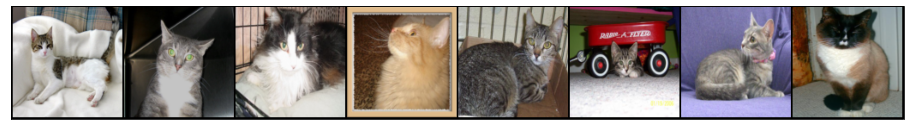

In [14]:
# original images
show_images(fixed_images, 8)

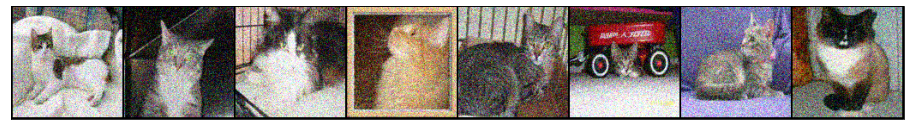

In [15]:
# images with noise
fixed_images_noised = add_gauss(fixed_images)
show_images(fixed_images_noised, 8)

In [16]:
# saving our test 'fixed_images'
os.makedirs('cats_denoise', exist_ok=True)
save_image(denorm(fixed_images), os.path.join('cats_denoise', 'fixed_images.png'), nrow=8)
save_image(denorm(fixed_images_noised), os.path.join('cats_denoise', 'fixed_images_noised.png'), nrow=8)

In [17]:
# function to save images: original, noised, denoised
def save_samples(x, y_true, y_predicted, epoch):
    
    orig_name = 'original-images-{0:0=4d}.png'.format(epoch)
    noise_name = 'images-with-noise-{0:0=4d}.png'.format(epoch)
    denoised_name = 'decoded-images-{0:0=4d}.png'.format(epoch)
    
    save_image(denorm(y_true), os.path.join('cats_denoise', orig_name), nrow=8)
    save_image(denorm(x), os.path.join('cats_denoise', noise_name), nrow=8)
    save_image(denorm(y_predicted), os.path.join('cats_denoise', denoised_name), nrow=8)
    
    print(f'Saving images for epoch {epoch}')

In [18]:
# function to check if gradients are exploding
def check_grads(model, value):
    grads = []
    for p in model.parameters():
        grads.append(p.grad.data.norm(2).item())

    grads = np.array(grads)
    if grads.mean() > value:
        print(f"WARNING! gradients mean is over {value}")
        print('max:', grads.max())
    if grads.max() > value:
        print(f"WARNING! gradients max is over {value}")
        print('max:', grads.max())

In [19]:
# set class of our autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                                    nn.Conv2d(3, 32, kernel_size=3, padding=2),
                                    nn.LeakyReLU(0.2, inplace=True),                                     
                            
                                    nn.Conv2d(32, 64, kernel_size=3, padding=2),
#                                     nn.BatchNorm2d(64),
                                    nn.LeakyReLU(0.2, inplace=True),                                    
                                     
                                    nn.Conv2d(64, 128, kernel_size=3, padding=2),
#                                     nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2, inplace=True),
            
                                    nn.Conv2d(128, 256, kernel_size=3, padding=2),
#                                     nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.2, inplace=True)                                  
                                    )
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2)
       
        self.decoder = nn.Sequential(    
                                    nn.ConvTranspose2d(256, 128, kernel_size=3, padding=2),
#                                     nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2, inplace=True),
            
                                    nn.ConvTranspose2d(128, 64, kernel_size=3, padding=2),
#                                     nn.BatchNorm2d(64),
                                    nn.LeakyReLU(0.2, inplace=True),
            
                                    nn.ConvTranspose2d(64, 32, kernel_size=3, padding=2),
#                                     nn.BatchNorm2d(32),
                                    nn.LeakyReLU(0.2, inplace=True),
                                                
                                    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=2),
                                    nn.Tanh() # [-1, 1] output
                                    )


    def forward(self, x):
        x = self.encoder(x)
        x, i = self.max_pool(x)
        x = self.max_unpool(x, i)
        x = self.decoder(x)
        return x

In [20]:
model = ConvAutoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, threshold=0.005, verbose=True)
summary(model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 130, 130]             896
         LeakyReLU-2         [-1, 32, 130, 130]               0
            Conv2d-3         [-1, 64, 132, 132]          18,496
         LeakyReLU-4         [-1, 64, 132, 132]               0
            Conv2d-5        [-1, 128, 134, 134]          73,856
         LeakyReLU-6        [-1, 128, 134, 134]               0
            Conv2d-7        [-1, 256, 136, 136]         295,168
         LeakyReLU-8        [-1, 256, 136, 136]               0
         MaxPool2d-9  [[-1, 256, 68, 68], [-1, 256, 68, 68]]               0
      MaxUnpool2d-10        [-1, 256, 136, 136]               0
  ConvTranspose2d-11        [-1, 128, 134, 134]         295,040
        LeakyReLU-12        [-1, 128, 134, 134]               0
  ConvTranspose2d-13         [-1, 64, 132, 132]          73,792
        LeakyReLU-14      

E:\anaconda\lib\site-packages\torch\nn\functional.py:693: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch._C._nn.max_pool2d_with_indices(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# function to plot losses
def plot_history(history, grid=True):
    plt.style.use('ggplot')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,7))
    ax1.plot(history['train_losses'], label='Loss on train dataset')
    ax2.plot(history['test_losses'], label='Loss on test dataset')
    ax3.plot(history['fixed_images_losses'], label='Loss on fixed_images')
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax3.set_xlabel('Epoch')
    ax1.set_ylabel('Loss, MSE')
    ax1.set_title(f'Loss on train dataset')
    ax2.set_title(f'Loss on test dataset')
    ax3.set_title(f'Loss on fixed_images')
    plt.show()

In [21]:
# main function to train model
def training_loop(model, epochs, history=None, plot_every=None, progress=True):
    torch.cuda.empty_cache()
    
    history = history or {
        'train_losses': [],
        'test_losses': [],
        'fixed_images_losses': []
    }
    
    # фиксируем параметры tqdm
    tqdm_ = partial(tqdm,
                    disable=not progress, # не показывать бар вообще
                    leave=True) # убрать бар после окончания
    
    start_epoch = len(history['train_losses'])
    for epoch in range(start_epoch+1, start_epoch+epochs+1):
        print(f'epoch {epoch}')
        print('current learning rate:', optimizer.param_groups[0]["lr"])
        
        # Setting train mode
        model.train()
        train_loss = 0 # for saving losses of train dataset
        for batch, x_train_batch in enumerate(tqdm_(train_loader, desc='train')):
            noise_images = add_gauss(x_train_batch).to(device) # images with noise (our 'X')
            x_train_batch = x_train_batch.to(device) # original images (our 'y_true')
            
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()
            
            # Forward pass: compute predicted y by passing x to the model
            y_pred = model(noise_images.float())
            
            # Computing loss
            loss = loss_fn(y_pred, x_train_batch.float())
            
            # Saving loss for this batch
            train_loss += loss.item()
            
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Checking norm of gradients         
#             check_grads(model, 0.7)

            # Clip gradients to avoid 'exploding gradients' problem 
#             nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.7, norm_type=2)

            # Calling the step function on an optimizer makes an update to its parameters
            optimizer.step()
            
        # Saving loss for this epoch
        history['train_losses'].append(train_loss)
        
        # Setting test mode
        model.eval()       
        test_loss = 0 # for saving losses on test dataset
        for batch, x_test_batch in enumerate(tqdm_(test_loader, desc='test')):
            noise_images = add_gauss(x_test_batch).to(device)
            x_test_batch = x_test_batch.to(device)
            # set inference_mode
            with torch.inference_mode():
                y_pred = model(noise_images.float())
                
            # Computing loss
            loss = loss_fn(y_pred, x_test_batch.float())
            
            # Saving loss for this batch
            test_loss += loss.item()
            
        # Calling the step function on a learning rate scheduler
        lr_scheduler.step(test_loss) 
            
        # Saving loss for this epoch
        history['test_losses'].append(test_loss)
        
        # Denoising and saving our 'fixed_images' to see the progression of autoencoder
        with torch.inference_mode():
            decoded = model(fixed_images_noised.to(device).float())
            
        # Saving loss for test 'fixed_images'
        history['fixed_images_losses'].append(loss_fn(decoded, fixed_images.to(device).float()).item())
        
        # Saving decoded 'fixed_images' 
        save_image(denorm(decoded), os.path.join('cats_denoise', 'fixed_images_decoded-{0:0=4d}.png'.format(epoch)), nrow=8)
        
        # Printing losses
        print(f'train: loss {history["train_losses"][-1]:.4f}\n'
              f'test: loss {history["test_losses"][-1]:.4f}\n'
              f'fixed_images: loss {history["fixed_images_losses"][-1]:.4f}')
        
        # Saving images from the last x_test_batch of the epoch
        save_samples(x=noise_images, y_true=x_test_batch, y_predicted=y_pred, epoch=epoch)

        if plot_every and epoch % plot_every == 0:
            plot_history(history)
        else:
            print()
    
    # Not to plot double
    if not plot_every or epoch % plot_every > 0:
        plot_history(history)
    
    # Show some images from the last epoch
    x_test_batch = x_test_batch.cpu()
    noise_images = noise_images.cpu()
    y_pred = y_pred.cpu()
    
    plt.figure(figsize=(16,7))
    for idx in range(4):
        plt.subplot(1,4,idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Original image {idx+1}')
        plt.imshow(denorm(x_test_batch[idx]).permute(1,2,0))
    plt.figure(figsize=(16,7))
    for idx in range(4):
        plt.subplot(1,4,idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Image with noise {idx+1}')
        plt.imshow(denorm(noise_images[idx]).permute(1,2,0))
    plt.figure(figsize=(16,7))
    for idx in range(4):
        plt.subplot(1,4,idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Decoded image {idx+1}')
        plt.imshow(denorm(y_pred[idx]).permute(1,2,0))

    return history

epoch 1
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 4.2885
test: loss 0.4534
fixed_images: loss 0.0056
Saving images for epoch 1

epoch 2
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.7541
test: loss 0.4584
fixed_images: loss 0.0057
Saving images for epoch 2

epoch 3
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.6301
test: loss 0.3982
fixed_images: loss 0.0050
Saving images for epoch 3

epoch 4
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.5984
test: loss 0.3812
fixed_images: loss 0.0047
Saving images for epoch 4

epoch 5
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.5278
test: loss 0.4039
fixed_images: loss 0.0050
Saving images for epoch 5

epoch 6
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.5036
test: loss 0.3688
fixed_images: loss 0.0046
Saving images for epoch 6

epoch 7
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.4651
test: loss 0.3579
fixed_images: loss 0.0044
Saving images for epoch 7

epoch 8
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.4410
test: loss 0.3687
fixed_images: loss 0.0046
Saving images for epoch 8

epoch 9
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.4558
test: loss 0.3581
fixed_images: loss 0.0044
Saving images for epoch 9

epoch 10
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.4140
test: loss 0.3561
fixed_images: loss 0.0044
Saving images for epoch 10

epoch 11
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.4129
test: loss 0.3563
fixed_images: loss 0.0044
Saving images for epoch 11

epoch 12
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.4098
test: loss 0.3502
fixed_images: loss 0.0044
Saving images for epoch 12

epoch 13
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.3912
test: loss 0.3421
fixed_images: loss 0.0042
Saving images for epoch 13

epoch 14
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.3796
test: loss 0.3388
fixed_images: loss 0.0042
Saving images for epoch 14

epoch 15
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.3906
test: loss 0.3537
fixed_images: loss 0.0044
Saving images for epoch 15

epoch 16
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.3724
test: loss 0.3391
fixed_images: loss 0.0042
Saving images for epoch 16

epoch 17
current learning rate: 0.001


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 5.0000e-04.
train: loss 1.3405
test: loss 0.3447
fixed_images: loss 0.0043
Saving images for epoch 17

epoch 18
current learning rate: 0.0005


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.3052
test: loss 0.3285
fixed_images: loss 0.0041
Saving images for epoch 18

epoch 19
current learning rate: 0.0005


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.3014
test: loss 0.3296
fixed_images: loss 0.0041
Saving images for epoch 19

epoch 20
current learning rate: 0.0005


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.3018
test: loss 0.3323
fixed_images: loss 0.0041
Saving images for epoch 20

epoch 21
current learning rate: 0.0005


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch    21: reducing learning rate of group 0 to 2.5000e-04.
train: loss 1.3003
test: loss 0.3329
fixed_images: loss 0.0041
Saving images for epoch 21

epoch 22
current learning rate: 0.00025


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2822
test: loss 0.3255
fixed_images: loss 0.0040
Saving images for epoch 22

epoch 23
current learning rate: 0.00025


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2810
test: loss 0.3238
fixed_images: loss 0.0040
Saving images for epoch 23

epoch 24
current learning rate: 0.00025


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2789
test: loss 0.3232
fixed_images: loss 0.0040
Saving images for epoch 24

epoch 25
current learning rate: 0.00025


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2778
test: loss 0.3233
fixed_images: loss 0.0040
Saving images for epoch 25

epoch 26
current learning rate: 0.00025


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch    26: reducing learning rate of group 0 to 1.2500e-04.
train: loss 1.2782
test: loss 0.3223
fixed_images: loss 0.0040
Saving images for epoch 26

epoch 27
current learning rate: 0.000125


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2687
test: loss 0.3209
fixed_images: loss 0.0040
Saving images for epoch 27

epoch 28
current learning rate: 0.000125


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2669
test: loss 0.3196
fixed_images: loss 0.0040
Saving images for epoch 28

epoch 29
current learning rate: 0.000125


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2663
test: loss 0.3207
fixed_images: loss 0.0040
Saving images for epoch 29

epoch 30
current learning rate: 0.000125


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch    30: reducing learning rate of group 0 to 6.2500e-05.
train: loss 1.2650
test: loss 0.3206
fixed_images: loss 0.0040
Saving images for epoch 30

epoch 31
current learning rate: 6.25e-05


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2605
test: loss 0.3186
fixed_images: loss 0.0040
Saving images for epoch 31

epoch 32
current learning rate: 6.25e-05


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2605
test: loss 0.3185
fixed_images: loss 0.0040
Saving images for epoch 32

epoch 33
current learning rate: 6.25e-05


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2606
test: loss 0.3188
fixed_images: loss 0.0040
Saving images for epoch 33

epoch 34
current learning rate: 6.25e-05


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch    34: reducing learning rate of group 0 to 3.1250e-05.
train: loss 1.2593
test: loss 0.3186
fixed_images: loss 0.0040
Saving images for epoch 34

epoch 35
current learning rate: 3.125e-05


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2569
test: loss 0.3179
fixed_images: loss 0.0039
Saving images for epoch 35

epoch 36
current learning rate: 3.125e-05


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2569
test: loss 0.3173
fixed_images: loss 0.0039
Saving images for epoch 36

epoch 37
current learning rate: 3.125e-05


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch    37: reducing learning rate of group 0 to 1.5625e-05.
train: loss 1.2563
test: loss 0.3181
fixed_images: loss 0.0039
Saving images for epoch 37

epoch 38
current learning rate: 1.5625e-05


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2549
test: loss 0.3172
fixed_images: loss 0.0039
Saving images for epoch 38

epoch 39
current learning rate: 1.5625e-05


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2550
test: loss 0.3178
fixed_images: loss 0.0039
Saving images for epoch 39

epoch 40
current learning rate: 1.5625e-05


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch    40: reducing learning rate of group 0 to 7.8125e-06.
train: loss 1.2543
test: loss 0.3173
fixed_images: loss 0.0039
Saving images for epoch 40

epoch 41
current learning rate: 7.8125e-06


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2543
test: loss 0.3175
fixed_images: loss 0.0039
Saving images for epoch 41

epoch 42
current learning rate: 7.8125e-06


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2533
test: loss 0.3166
fixed_images: loss 0.0039
Saving images for epoch 42

epoch 43
current learning rate: 7.8125e-06


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2535
test: loss 0.3168
fixed_images: loss 0.0039
Saving images for epoch 43

epoch 44
current learning rate: 7.8125e-06


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2534
test: loss 0.3171
fixed_images: loss 0.0039
Saving images for epoch 44

epoch 45
current learning rate: 7.8125e-06


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch    45: reducing learning rate of group 0 to 3.9063e-06.
train: loss 1.2538
test: loss 0.3167
fixed_images: loss 0.0039
Saving images for epoch 45

epoch 46
current learning rate: 3.90625e-06


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2529
test: loss 0.3174
fixed_images: loss 0.0039
Saving images for epoch 46

epoch 47
current learning rate: 3.90625e-06


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2529
test: loss 0.3172
fixed_images: loss 0.0039
Saving images for epoch 47

epoch 48
current learning rate: 3.90625e-06


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch    48: reducing learning rate of group 0 to 1.9531e-06.
train: loss 1.2530
test: loss 0.3172
fixed_images: loss 0.0039
Saving images for epoch 48

epoch 49
current learning rate: 1.953125e-06


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2526
test: loss 0.3177
fixed_images: loss 0.0039
Saving images for epoch 49

epoch 50
current learning rate: 1.953125e-06


train:   0%|          | 0/313 [00:00<?, ?it/s]

test:   0%|          | 0/79 [00:00<?, ?it/s]

train: loss 1.2527
test: loss 0.3170
fixed_images: loss 0.0039
Saving images for epoch 50



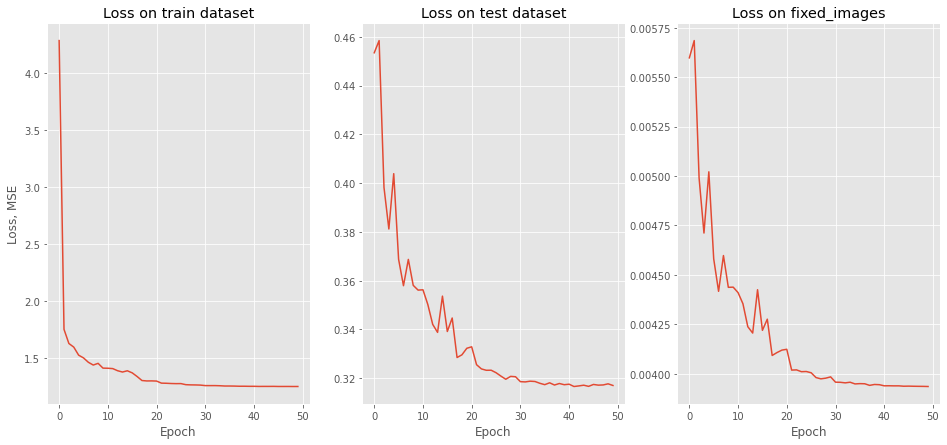

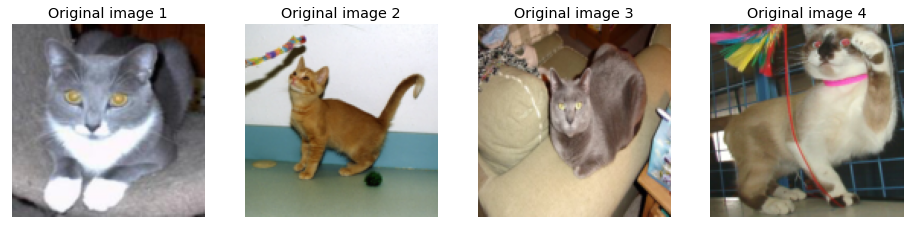

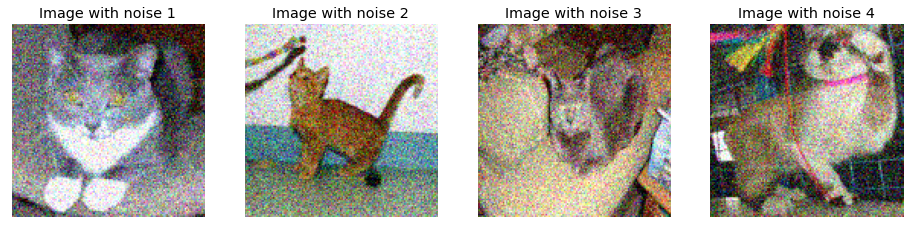

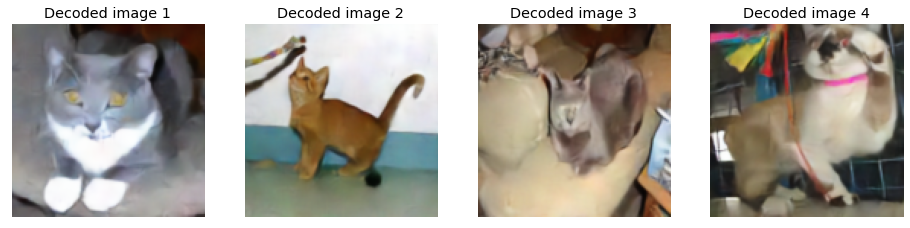

In [22]:
history = training_loop(model, 50)